In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# data load

In [2]:
d1221 = pd.read_feather('d1221_10thr.ftr', use_threads = True, columns = None)

In [3]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random

2022-06-23 13:11:54.709226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## mk_cd 함수

In [4]:
## 함수
def mk_cd(x):
    if type(x) == str:
        if x.isalpha():
            return x
        else:
            if len(x) == 6:
                return x
            else:
                return "0"*(6-len(x))+x
    elif type(x) == int:
        x = str(x)
        return "0"*(6-len(x))+x

# 슬라이싱 준비

In [5]:
sum((20120000<d1221['date'])&(d1221['date']<20130000)) # 107935
sum((20130000<d1221['date'])&(d1221['date']<20140000))
sum((20140000<d1221['date'])&(d1221['date']<20150000))
sum((20150000<d1221['date'])&(d1221['date']<20160000))
sum((20160000<d1221['date'])&(d1221['date']<20170000))
sum((20170000<d1221['date'])&(d1221['date']<20180000))
sum((20180000<d1221['date'])&(d1221['date']<20190000))
sum((20190000<d1221['date'])&(d1221['date']<20200000))
sum((20200000<d1221['date'])&(d1221['date']<20210000))
sum((20210000<d1221['date'])&(d1221['date']<20220000))


107935

93840

95437

158287

134332

110782

159382

133987

222267

223622

In [6]:
len_a2012 = sum((20120000<d1221['date'])&(d1221['date']<20130000)) # 107935
len_a2013 = sum((20130000<d1221['date'])&(d1221['date']<20140000))
len_a2014 = sum((20140000<d1221['date'])&(d1221['date']<20150000))
len_a2015 = sum((20150000<d1221['date'])&(d1221['date']<20160000))
len_a2016 = sum((20160000<d1221['date'])&(d1221['date']<20170000))
len_a2017 = sum((20170000<d1221['date'])&(d1221['date']<20180000))
len_a2018 = sum((20180000<d1221['date'])&(d1221['date']<20190000))
len_a2019 = sum((20190000<d1221['date'])&(d1221['date']<20200000))
len_a2020 = sum((20200000<d1221['date'])&(d1221['date']<20210000))
len_a2021 = sum((20210000<d1221['date'])&(d1221['date']<20220000))

In [7]:
len1215 = len_a2012+len_a2013+len_a2014+len_a2015 # y:2015
len1316 = len1215+len_a2016 # y:2016
len1417 = len1316+len_a2017 # y:2017
len1518 = len1417+len_a2018 # y:2018
len1619 = len1518+len_a2019 # y:2019
len1720 = len1619+len_a2020 # y:2020
len1821 = len1720+len_a2021 # y:2021

## [0], [1]은 train 슬라이싱 인덱스, [2]는 test인덱스로 구성

In [8]:
slicing_dic = {'1215':[0, len1215, len_a2015],
               '1316':[len_a2012, len1316, len_a2016],
               '1417':[len_a2012+len_a2013, len1417, len_a2017],
               '1518':[len_a2012+len_a2013+len_a2014, len1518, len_a2018],
               '1619':[len_a2012+len_a2013+len_a2014+len_a2015, len1619, len_a2019],
               '1720':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016,len1720, len_a2020],
               '1821':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016+len_a2017,len1821, len_a2021]}

# category to object

In [9]:
d1221['code'] = list(map(mk_cd, d1221['code'])) # mk_cd함수 적용시켜야 ftr만들 때 에러 안남.

In [10]:
d1221.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439871 entries, 0 to 1439870
Columns: 823 entries, date to NextChange
dtypes: float64(821), int64(1), object(1)
memory usage: 8.8+ GB


# reg modeling

In [30]:
results = []
def my_regressor():
    X = d1221.iloc[:,2:-1] # 1221 데이터
    y = d1221.iloc[:,-1]
    from sklearn.linear_model import LinearRegression # 일반 회귀 모델
    from sklearn.linear_model import Ridge, Lasso, ElasticNet # Norm 규제 회귀 모델
    from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor # decision tree 앙상블 모델, 배깅
    from xgboost import XGBRegressor # decision tree 앙상블 모델, 부스팅
    import lightgbm as lgb
    from sklearn.model_selection import GridSearchCV
#     from sklearn.model_selection import cross_val_score # model 검증
    
#     from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import cross_val_score
    
    from sklearn.dummy import DummyRegressor
    from sklearn.metrics import mean_squared_error as mse # 모델 평가 지표 scoring (mse)
    from sklearn.metrics import r2_score as r2
    
    import ast # convert string to function
    
    # seed 고정
    user_seed = 0
    random.seed(user_seed) # seed 고정
    
    # (같은 줄에 써놓은 애들끼리 하이퍼파리미터 구성 비슷하거나 같음)
    linear = LinearRegression(n_jobs=64)
    ridge, lasso, elasticnet = Ridge(), Lasso(alpha=0.01, max_iter=10, random_state=user_seed), ElasticNet(alpha=0.01, max_iter=10, random_state=user_seed)
    # [lasso 학습시간 단축 하이퍼파라미터 참고](https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-3-%EC%84%A0%ED%98%95-%EB%AA%A8%EB%8D%B8/comment-page-1/)
    # [elastic net 참고](https://soobarkbar.tistory.com/30)
    # elastic net은 큰 데이터 셋에서 잘 작동함. + ridge&lasso의 장점 모두 가짐.
    # [모델훈련](https://taek98.tistory.com/15)
    ardr_linear, bayesian_ridge = ARDRegression(verbose = True), BayesianRidge(verbose = True) # n_iter=10, 
    DecisionTree = DecisionTreeRegressor(max_depth = 10, random_state=user_seed, max_leaf_nodes=4)
    random_forest = RandomForestRegressor(n_estimators=10,
                                          n_jobs=64,
                                          max_depth=10,
                                          random_state=user_seed,
                                          verbose=2,
                                          max_leaf_nodes=4)
    xgboost_linear = XGBRegressor(n_jobs=64, max_depth=10, n_estimators=10, learning_rate=0.05) # 16에서 64로 증가 # , verbosity=2
    gbm = lgb.LGBMRegressor(num_leaves=31,
                            learning_rate=0.05,
                            n_estimators=20)

    dummy = DummyRegressor(strategy = 'mean')
    
    my_model_list = ['DecisionTree', 'random_forest',
                     'xgboost_linear', 'gbm', 'dummy',
                     
                     'linear', 'ridge', 'lasso', 'elasticnet',
                     'ardr_linear', 'bayesian_ridge'] # 오래 걸리는걸 앞으로 뺌
    
    i = 0
    
    ######################################################################### fitting
    for model_nm in tqdm(my_model_list):
        cntcnt = 0
        # cv
        for slicer in slicing_dic:
            tmpX = X[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True)
            tmpy = y[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True)
#             tmp_all = d1221[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # 전체데이터

            X_train = tmpX[:-slicing_dic[slicer][2]]
            X_test = tmpX[-slicing_dic[slicer][2]:]
            y_train = tmpy[:-slicing_dic[slicer][2]]
            y_test = tmpy[-slicing_dic[slicer][2]:]
            
            # train끼리 idx 같아야 하므로
            len_train = slicing_dic[slicer][1]-(slicing_dic[slicer][2]+slicing_dic[slicer][0]) # 혹은 tmp_train.shape[0]
            len(list(range(len_train)))
            train_idx = list(range(len_train))
            random.shuffle(train_idx) # 자동으로 덮어쓰기

            len_train_to_test = slicing_dic[slicer][1]-slicing_dic[slicer][0]
            test_idx = list(range(len_train,len_train_to_test)) # +1 안해줘도 되는 거 위 cell에서 확인
            len(test_idx)
            random.shuffle(test_idx) # 자동으로 덮어쓰기
            
            X_train = X_train.loc[train_idx]
            y_train = y_train.loc[train_idx]
            X_test = X_test.loc[test_idx]
            y_test = y_test.loc[test_idx]
            ###########################################
            y_train = np.array(y_train).reshape(-1,1) # 1열짜리로 만드는 것
            y_test = np.array(y_test).reshape(-1,1)

            ######################################################## cv를 위한 데이터 slicing 작업 끝

            # fitting은 cv 안에 넣기
            if model_nm == 'gbm':
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='l1',
                                            early_stopping_rounds=5)
                y_pred_test = model_.predict(X_test, num_iteration=gbm.best_iteration_) # 예측

            elif model_nm == 'xgboost_linear': # xgboost_linear가 느려서
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='rmse',
                                            early_stopping_rounds=5) # ,verbose = True
                y_pred_test = model_.predict(X_test) # 예측
                
            else:
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train)
                y_pred_test = model_.predict(X_test) # 예측

            mse_score = mse(y_test, y_pred_test)
            r2_score = r2(y_test, y_pred_test)
#             cv_scores = cross_val_score(eval(model_nm), tmpX, tmpy, cv=7)

            results.append([i, f'{model_nm}', mse_score, r2_score]) # , cv_scores #[:str(model).index("(")]
            i+=1
        ################################################################
        print(results[-7:])
    return results#score_dic#[0]

In [31]:
# 최종
import time
start = time.time()
_ = my_regressor()
results
time.time()-start

  0%|                                                    | 0/11 [00:00<?, ?it/s]

$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


  9%|███▋                                     | 1/11 [12:36<2:06:04, 756.44s/it]

[[0, 'DecisionTree', 22.794256645140226, -0.0011155847315544865], [1, 'DecisionTree', 18.96271388027769, -0.0014687302722780071], [2, 'DecisionTree', 18.124000488338556, 0.0011064808393549397], [3, 'DecisionTree', 21.51762591563431, -0.001251284154066612], [4, 'DecisionTree', 19.81580289630115, 0.005772318106706087], [5, 'DecisionTree', 27.269565673037228, 0.00019830218510685782], [6, 'DecisionTree', 19.032642691370285, -0.0021424921225838833]]
$$$$$---1


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:   47.2s remaining:  1.8min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---2


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:   55.8s remaining:  2.2min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---3


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.5min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---4


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---5


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.7min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---6


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---7


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.5min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  1.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
 18%|███████▍                                 | 2/11 [22:46<1:40:31, 670.17s/it]

[[7, 'random_forest', 22.780907625720165, -0.0005293005815447671], [8, 'random_forest', 18.93809401437832, -0.00016849308063027202], [9, 'random_forest', 18.100895413712855, 0.00237990330026161], [10, 'random_forest', 21.430550372951856, 0.0028004871366440476], [11, 'random_forest', 19.851966790214593, 0.003957849896563226], [12, 'random_forest', 27.33704284646527, -0.002275657003169007], [13, 'random_forest', 19.01724333665828, -0.0013316563412153481]]
$$$$$---1
[0]	validation_0-rmse:4.78289
[1]	validation_0-rmse:4.78007
[2]	validation_0-rmse:4.77762
[3]	validation_0-rmse:4.77574
[4]	validation_0-rmse:4.77410
[5]	validation_0-rmse:4.77307
[6]	validation_0-rmse:4.77256
[7]	validation_0-rmse:4.77172
[8]	validation_0-rmse:4.77097
[9]	validation_0-rmse:4.77069
$$$$$---2
[0]	validation_0-rmse:4.37188
[1]	validation_0-rmse:4.36848
[2]	validation_0-rmse:4.36531
[3]	validation_0-rmse:4.36267
[4]	validation_0-rmse:4.36026
[5]	validation_0-rmse:4.35844
[6]	validation_0-rmse:4.35717
[7]	validati

 27%|███████████▋                               | 3/11 [24:41<55:32, 416.57s/it]

[[14, 'xgboost_linear', 22.759476320043927, 0.0004119546849744582], [15, 'xgboost_linear', 18.950053650763202, -0.0008001116316724843], [16, 'xgboost_linear', 18.217737328199465, -0.004059769399046509], [17, 'xgboost_linear', 21.547575993560862, -0.0026449115970779147], [18, 'xgboost_linear', 19.950277990636852, -0.0009747646137581167], [19, 'xgboost_linear', 27.231096491384108, 0.0016087226366644503], [20, 'xgboost_linear', 18.983430803998893, 0.00044870470972901977]]
[1]	valid_0's l1: 3.09531	valid_0's l2: 22.7706
[2]	valid_0's l1: 3.09462	valid_0's l2: 22.757
[3]	valid_0's l1: 3.09382	valid_0's l2: 22.7422
[4]	valid_0's l1: 3.09326	valid_0's l2: 22.7314
[5]	valid_0's l1: 3.09272	valid_0's l2: 22.7223
[6]	valid_0's l1: 3.09229	valid_0's l2: 22.715
[7]	valid_0's l1: 3.09186	valid_0's l2: 22.7075
[8]	valid_0's l1: 3.09163	valid_0's l2: 22.7031
[9]	valid_0's l1: 3.09115	valid_0's l2: 22.6968
[10]	valid_0's l1: 3.09078	valid_0's l2: 22.6896
[11]	valid_0's l1: 3.09048	valid_0's l2: 22.685

 36%|███████████████▋                           | 4/11 [26:12<33:37, 288.22s/it]

[[21, 'gbm', 22.66350550393702, 0.004626958542295334], [22, 'gbm', 18.839675493713678, 0.005029237136024434], [23, 'gbm', 18.067964670981414, 0.004194861621231949], [24, 'gbm', 21.42896031286685, 0.0028744753037511783], [25, 'gbm', 19.88597288795631, 0.002251645817681558], [26, 'gbm', 27.186348184555268, 0.0032493587097960352], [27, 'gbm', 18.918224488273914, 0.0038820702597682777]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6


 45%|███████████████████▌                       | 5/11 [26:28<19:01, 190.19s/it]

$$$$$---7
[[28, 'dummy', 22.78603871796385, -0.0007546563144305019], [29, 'dummy', 18.935811983865147, -4.7973295598247034e-05], [30, 'dummy', 18.151718651034788, -0.00042118922985090457], [31, 'dummy', 21.4990648745393, -0.0003876077287734425], [32, 'dummy', 19.93132568806165, -2.3861743231767818e-05], [33, 'dummy', 27.322843262729894, -0.001755048494140432], [34, 'dummy', 18.99269042730624, -3.885038852091682e-05]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


 55%|███████████████████████▍                   | 6/11 [27:23<12:00, 144.01s/it]

[[35, 'linear', 23.077135649022804, -0.013539529227264424], [36, 'linear', 19.09897137410644, -0.008664832064262828], [37, 'linear', 18.280346149303995, -0.00751041737733571], [38, 'linear', 22.425477405919477, -0.043495139216569445], [39, 'linear', 20.046425022850755, -0.005798795285601344], [40, 'linear', 27.87582797086563, -0.022029483983461162], [41, 'linear', 19.309977548570078, -0.016745248526595313]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


 64%|███████████████████████████▎               | 7/11 [28:12<07:32, 113.06s/it]

[[42, 'ridge', 23.306065148729115, -0.02359403082951994], [43, 'ridge', 19.06005737390709, -0.006609685600760473], [44, 'ridge', 18.237283396521025, -0.005137039341961858], [45, 'ridge', 22.232039999332216, -0.034494171707035504], [46, 'ridge', 20.025810793077458, -0.0047645077531315305], [47, 'ridge', 27.817106926808627, -0.019876556421299707], [48, 'ridge', 19.261822189369003, -0.014209682002209734]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


 73%|████████████████████████████████            | 8/11 [29:14<04:49, 96.66s/it]

[[49, 'lasso', 22.771354279694453, -0.00010972104703443897], [50, 'lasso', 18.93238326741051, 0.00013310586511483535], [51, 'lasso', 18.146462805806493, -0.00013151644267406226], [52, 'lasso', 21.45077175674837, 0.001859552176020851], [53, 'lasso', 19.91729404759222, 0.0006801544124640513], [54, 'lasso', 27.356152534703206, -0.002976287844674852], [55, 'lasso', 19.04984034423305, -0.0030480152797209836]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


 82%|████████████████████████████████████        | 9/11 [30:12<02:49, 84.61s/it]

[[56, 'elasticnet', 22.770731941986828, -8.238819789774254e-05], [57, 'elasticnet', 18.93048798894362, 0.0002332002994733795], [58, 'elasticnet', 18.14750007677335, -0.00018868501575330932], [59, 'elasticnet', 21.449773483456372, 0.0019060035094284888], [60, 'elasticnet', 19.91649399489795, 0.0007202958359422418], [61, 'elasticnet', 27.364896630258233, -0.003296878267220915], [62, 'elasticnet', 19.04955444453375, -0.003032961551145519]]
$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


 91%|███████████████████████████████████████    | 10/11 [31:14<01:17, 77.79s/it]

[[63, 'ardr_linear', 22.78603871796386, -0.0007546563144307239], [64, 'ardr_linear', 18.93581198386515, -4.797329559846908e-05], [65, 'ardr_linear', 18.151718651034784, -0.00042118922985090457], [66, 'ardr_linear', 21.4990648745393, -0.0003876077287734425], [67, 'ardr_linear', 19.931325688061655, -2.3861743232211907e-05], [68, 'ardr_linear', 27.322843262729894, -0.0017550484941408762], [69, 'ardr_linear', 18.992690427306236, -3.8850388520472734e-05]]
$$$$$---1
Convergence after  32  iterations
$$$$$---2
Convergence after  20  iterations
$$$$$---3
Convergence after  92  iterations
$$$$$---4
Convergence after  81  iterations
$$$$$---5
Convergence after  89  iterations
$$$$$---6
Convergence after  166  iterations
$$$$$---7
Convergence after  44  iterations


100%|██████████████████████████████████████████| 11/11 [34:07<00:00, 186.17s/it]

[[70, 'bayesian_ridge', 39.818135870151224, -0.7487982606822892], [71, 'bayesian_ridge', 236.85940524581002, -11.509142379207521], [72, 'bayesian_ridge', 18.22978282334477, -0.004723649707561339], [73, 'bayesian_ridge', 22.190173980930584, -0.032546075534557684], [74, 'bayesian_ridge', 19.976560771010536, -0.002293463025393905], [75, 'bayesian_ridge', 27.42650592924302, -0.005555699785126267], [76, 'bayesian_ridge', 352.461131627053, -17.558446273214344]]


[[0, 'DecisionTree', 22.794256645140226, -0.0011155847315544865],
 [1, 'DecisionTree', 18.96271388027769, -0.0014687302722780071],
 [2, 'DecisionTree', 18.124000488338556, 0.0011064808393549397],
 [3, 'DecisionTree', 21.51762591563431, -0.001251284154066612],
 [4, 'DecisionTree', 19.81580289630115, 0.005772318106706087],
 [5, 'DecisionTree', 27.269565673037228, 0.00019830218510685782],
 [6, 'DecisionTree', 19.032642691370285, -0.0021424921225838833],
 [7, 'random_forest', 22.780907625720165, -0.0005293005815447671],
 [8, 'random_forest', 18.93809401437832, -0.00016849308063027202],
 [9, 'random_forest', 18.100895413712855, 0.00237990330026161],
 [10, 'random_forest', 21.430550372951856, 0.0028004871366440476],
 [11, 'random_forest', 19.851966790214593, 0.003957849896563226],
 [12, 'random_forest', 27.33704284646527, -0.002275657003169007],
 [13, 'random_forest', 19.01724333665828, -0.0013316563412153481],
 [14, 'xgboost_linear', 22.759476320043927, 0.0004119546849744582],
 [15, 'xgboos

2049.074299812317

In [33]:
results

[[0, 'DecisionTree', 22.794256645140226, -0.0011155847315544865],
 [1, 'DecisionTree', 18.96271388027769, -0.0014687302722780071],
 [2, 'DecisionTree', 18.124000488338556, 0.0011064808393549397],
 [3, 'DecisionTree', 21.51762591563431, -0.001251284154066612],
 [4, 'DecisionTree', 19.81580289630115, 0.005772318106706087],
 [5, 'DecisionTree', 27.269565673037228, 0.00019830218510685782],
 [6, 'DecisionTree', 19.032642691370285, -0.0021424921225838833],
 [7, 'random_forest', 22.780907625720165, -0.0005293005815447671],
 [8, 'random_forest', 18.93809401437832, -0.00016849308063027202],
 [9, 'random_forest', 18.100895413712855, 0.00237990330026161],
 [10, 'random_forest', 21.430550372951856, 0.0028004871366440476],
 [11, 'random_forest', 19.851966790214593, 0.003957849896563226],
 [12, 'random_forest', 27.33704284646527, -0.002275657003169007],
 [13, 'random_forest', 19.01724333665828, -0.0013316563412153481],
 [14, 'xgboost_linear', 22.759476320043927, 0.0004119546849744582],
 [15, 'xgboos

In [27]:
results = [[0, 'DecisionTree', 22.794256645140226, -0.0011155847315544865],
 [1, 'DecisionTree', 18.96271388027769, -0.0014687302722780071],
 [2, 'DecisionTree', 18.124000488338556, 0.0011064808393549397],
 [3, 'DecisionTree', 21.51762591563431, -0.001251284154066612],
 [4, 'DecisionTree', 19.81580289630115, 0.005772318106706087],
 [5, 'DecisionTree', 27.269565673037228, 0.00019830218510685782],
 [6, 'DecisionTree', 19.032642691370285, -0.0021424921225838833],
 [7, 'random_forest', 22.780907625720165, -0.0005293005815447671],
 [8, 'random_forest', 18.93809401437832, -0.00016849308063027202],
 [9, 'random_forest', 18.100895413712855, 0.00237990330026161],
 [10, 'random_forest', 21.430550372951856, 0.0028004871366440476],
 [11, 'random_forest', 19.851966790214593, 0.003957849896563226],
 [12, 'random_forest', 27.33704284646527, -0.002275657003169007],
 [13, 'random_forest', 19.01724333665828, -0.0013316563412153481],
 [14, 'xgboost_linear', 22.759476320043927, 0.0004119546849744582],
 [15, 'xgboost_linear', 18.950053650763202, -0.0008001116316724843],
 [16, 'xgboost_linear', 18.217737328199465, -0.004059769399046509],
 [17, 'xgboost_linear', 21.547575993560862, -0.0026449115970779147],
 [18, 'xgboost_linear', 19.950277990636852, -0.0009747646137581167],
 [19, 'xgboost_linear', 27.231096491384108, 0.0016087226366644503],
 [20, 'xgboost_linear', 18.983430803998893, 0.00044870470972901977],
 [21, 'gbm', 22.66350550393702, 0.004626958542295334],
 [22, 'gbm', 18.839675493713678, 0.005029237136024434],
 [23, 'gbm', 18.067964670981414, 0.004194861621231949],
 [24, 'gbm', 21.42896031286685, 0.0028744753037511783],
 [25, 'gbm', 19.88597288795631, 0.002251645817681558],
 [26, 'gbm', 27.186348184555268, 0.0032493587097960352],
 [27, 'gbm', 18.918224488273914, 0.0038820702597682777],
 [28, 'dummy', 22.78603871796385, -0.0007546563144305019],
 [29, 'dummy', 18.935811983865147, -4.7973295598247034e-05],
 [30, 'dummy', 18.151718651034788, -0.00042118922985090457],
 [31, 'dummy', 21.4990648745393, -0.0003876077287734425],
 [32, 'dummy', 19.93132568806165, -2.3861743231767818e-05],
 [33, 'dummy', 27.322843262729894, -0.001755048494140432],
 [34, 'dummy', 18.99269042730624, -3.885038852091682e-05],
 [35, 'linear', 23.077135649022804, -0.013539529227264424],
 [36, 'linear', 19.09897137410644, -0.008664832064262828],
 [37, 'linear', 18.280346149303995, -0.00751041737733571],
 [38, 'linear', 22.425477405919477, -0.043495139216569445],
 [39, 'linear', 20.046425022850755, -0.005798795285601344],
 [40, 'linear', 27.87582797086563, -0.022029483983461162],
 [41, 'linear', 19.309977548570078, -0.016745248526595313],
 [42, 'ridge', 23.306065148729115, -0.02359403082951994],
 [43, 'ridge', 19.06005737390709, -0.006609685600760473],
 [44, 'ridge', 18.237283396521025, -0.005137039341961858],
 [45, 'ridge', 22.232039999332216, -0.034494171707035504],
 [46, 'ridge', 20.025810793077458, -0.0047645077531315305],
 [47, 'ridge', 27.817106926808627, -0.019876556421299707],
 [48, 'ridge', 19.261822189369003, -0.014209682002209734],
 [49, 'lasso', 22.771354279694453, -0.00010972104703443897],
 [50, 'lasso', 18.93238326741051, 0.00013310586511483535],
 [51, 'lasso', 18.146462805806493, -0.00013151644267406226],
 [52, 'lasso', 21.45077175674837, 0.001859552176020851],
 [53, 'lasso', 19.91729404759222, 0.0006801544124640513],
 [54, 'lasso', 27.356152534703206, -0.002976287844674852],
 [55, 'lasso', 19.04984034423305, -0.0030480152797209836],
 [56, 'elasticnet', 22.770731941986828, -8.238819789774254e-05],
 [57, 'elasticnet', 18.93048798894362, 0.0002332002994733795],
 [58, 'elasticnet', 18.14750007677335, -0.00018868501575330932],
 [59, 'elasticnet', 21.449773483456372, 0.0019060035094284888],
 [60, 'elasticnet', 19.91649399489795, 0.0007202958359422418],
 [61, 'elasticnet', 27.364896630258233, -0.003296878267220915],
 [62, 'elasticnet', 19.04955444453375, -0.003032961551145519],
 [63, 'ardr_linear', 22.78603871796386, -0.0007546563144307239],
 [64, 'ardr_linear', 18.93581198386515, -4.797329559846908e-05],
 [65, 'ardr_linear', 18.151718651034784, -0.00042118922985090457],
 [66, 'ardr_linear', 21.4990648745393, -0.0003876077287734425],
 [67, 'ardr_linear', 19.931325688061655, -2.3861743232211907e-05],
 [68, 'ardr_linear', 27.322843262729894, -0.0017550484941408762],
 [69, 'ardr_linear', 18.992690427306236, -3.8850388520472734e-05],
 [70, 'bayesian_ridge', 39.818135870151224, -0.7487982606822892],
 [71, 'bayesian_ridge', 236.85940524581002, -11.509142379207521],
 [72, 'bayesian_ridge', 18.22978282334477, -0.004723649707561339],
 [73, 'bayesian_ridge', 22.190173980930584, -0.032546075534557684],
 [74, 'bayesian_ridge', 19.976560771010536, -0.002293463025393905],
 [75, 'bayesian_ridge', 27.42650592924302, -0.005555699785126267],
 [76, 'bayesian_ridge', 352.461131627053, -17.558446273214344]]

In [29]:
nm_dic = {i:'' for i in ['linear', 'ridge', 'lasso', 'elasticnet',
              'ardr_linear', 'bayesian_ridge',
              'DecisionTree', 'random_forest',
              'xgboost_linear', 'gbm', 'dummy']}

nm_list = ['Linear', 'Ridge', 'Lasso', 'ElasticNet',
              'ARDR_Linear', 'Bayesian_Ridge',
              'DecisionTree', 'Random_Forest',
              'XGBoost_Linear', 'LGBM', 'dummy']
for idx,i in enumerate(nm_dic):
    nm_dic[i] = nm_list[idx]
    

for i in range(len(results)):
#     results[i][1] = (results[i][1][0]).upper()+results[i][1][1:]

    if results[i][1] in nm_dic:
        results[i][1] = nm_dic[results[i][1]]
    
results

[[0, 'DecisionTree', 22.794256645140226, -0.0011155847315544865],
 [1, 'DecisionTree', 18.96271388027769, -0.0014687302722780071],
 [2, 'DecisionTree', 18.124000488338556, 0.0011064808393549397],
 [3, 'DecisionTree', 21.51762591563431, -0.001251284154066612],
 [4, 'DecisionTree', 19.81580289630115, 0.005772318106706087],
 [5, 'DecisionTree', 27.269565673037228, 0.00019830218510685782],
 [6, 'DecisionTree', 19.032642691370285, -0.0021424921225838833],
 [7, 'Random_Forest', 22.780907625720165, -0.0005293005815447671],
 [8, 'Random_Forest', 18.93809401437832, -0.00016849308063027202],
 [9, 'Random_Forest', 18.100895413712855, 0.00237990330026161],
 [10, 'Random_Forest', 21.430550372951856, 0.0028004871366440476],
 [11, 'Random_Forest', 19.851966790214593, 0.003957849896563226],
 [12, 'Random_Forest', 27.33704284646527, -0.002275657003169007],
 [13, 'Random_Forest', 19.01724333665828, -0.0013316563412153481],
 [14, 'XGBoost_Linear', 22.759476320043927, 0.0004119546849744582],
 [15, 'XGBoos

## plot을 위한 준비

In [30]:
model_list = ['Linear', 'Ridge', 'Lasso', 'ElasticNet',
              'ARDR_Linear', 'Bayesian_Ridge',
              'DecisionTree', 'Random_Forest',
              'XGBoost_Linear', 'LGBM', 'dummy']
# ['linear', 'ridge', 'lasso', 'elasticnet', 'ardr_linear', 'bayesian_ridge', 'DecisionTree', 'random_forest', 'xgboost_linear', 'lgbm', 'dummy']
mse_dic = {i:[] for i in model_list}
r2_dic = {i:[] for i in model_list}

for i in results:
    mse_dic[i[1]].append(i[2])
    r2_dic[i[1]].append(i[3])



# import math
# 리스트에 mean 함수가 내장이 안돼있다니...
mean_mse_score = {i:[] for i in model_list}
mean_r2_score = {i:[] for i in model_list}

for i in model_list:
    mean_mse_score[i] = sum(mse_dic[i])/len(mse_dic[i])
    mean_r2_score[i] = sum(r2_dic[i])/len(r2_dic[i])



# 정렬
mse_score_lst = sorted(mean_mse_score.items(), key = lambda t : t[1], reverse = True) #mse 큰 순으로 줄 세워짐. (클 수혹 안좋으니까)
r2_score_lst = sorted(mean_r2_score.items(), key = lambda t : t[1]) #r2 작은 순으로 줄 세워짐.

mse_score_lst
r2_score_lst


[('Bayesian_Ridge', 102.42309946393473),
 ('Linear', 21.444880160091316),
 ('Ridge', 21.420026546820647),
 ('XGBoost_Linear', 21.091378368369615),
 ('ElasticNet', 21.08991979440716),
 ('Lasso', 21.089179862312616),
 ('ARDR_Linear', 21.088499086500125),
 ('dummy', 21.08849908650012),
 ('DecisionTree', 21.073801170014207),
 ('Random_Forest', 21.065242914300192),
 ('LGBM', 20.998664506040637)]

[('Bayesian_Ridge', -4.265929400165256),
 ('Linear', -0.01682620652587003),
 ('Ridge', -0.015526524807988393),
 ('XGBoost_Linear', -0.0008585964585981566),
 ('ElasticNet', -0.0005344876267390537),
 ('Lasso', -0.0005132468800720856),
 ('ARDR_Linear', -0.0004898838849353002),
 ('dummy', -0.0004898838849351732),
 ('DecisionTree', 0.00015700140724069937),
 ('Random_Forest', 0.000690447618129927),
 ('LGBM', 0.003729801055792681)]

In [31]:
# 다시 dic
mse_score_dic = {}
r2_score_dic = {}


for i in mse_score_lst:
    mse_score_dic[i[0]] = i[1]
r2_score_dic = {i[0]:i[1] for i in r2_score_lst}


In [32]:
mse_df = pd.DataFrame(mse_score_dic.items(), columns=['key', 'value'])
mse_df

r2_df = pd.DataFrame(r2_score_dic.items(), columns=['key', 'value'])
r2_df


,key,value
0,Bayesian_Ridge,102.423099
1,Linear,21.444880
2,Ridge,21.420027
3,XGBoost_Linear,21.091378
4,ElasticNet,21.089920
5,Lasso,21.089180
6,ARDR_Linear,21.088499
7,dummy,21.088499
8,DecisionTree,21.073801
9,Random_Forest,21.065243


,key,value
0,Bayesian_Ridge,-4.265929
1,Linear,-0.016826
2,Ridge,-0.015527
3,XGBoost_Linear,-0.000859
4,ElasticNet,-0.000534
5,Lasso,-0.000513
6,ARDR_Linear,-0.000490
7,dummy,-0.000490
8,DecisionTree,0.000157
9,Random_Forest,0.000690


## MSE plot

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1500x900 with 0 Axes>

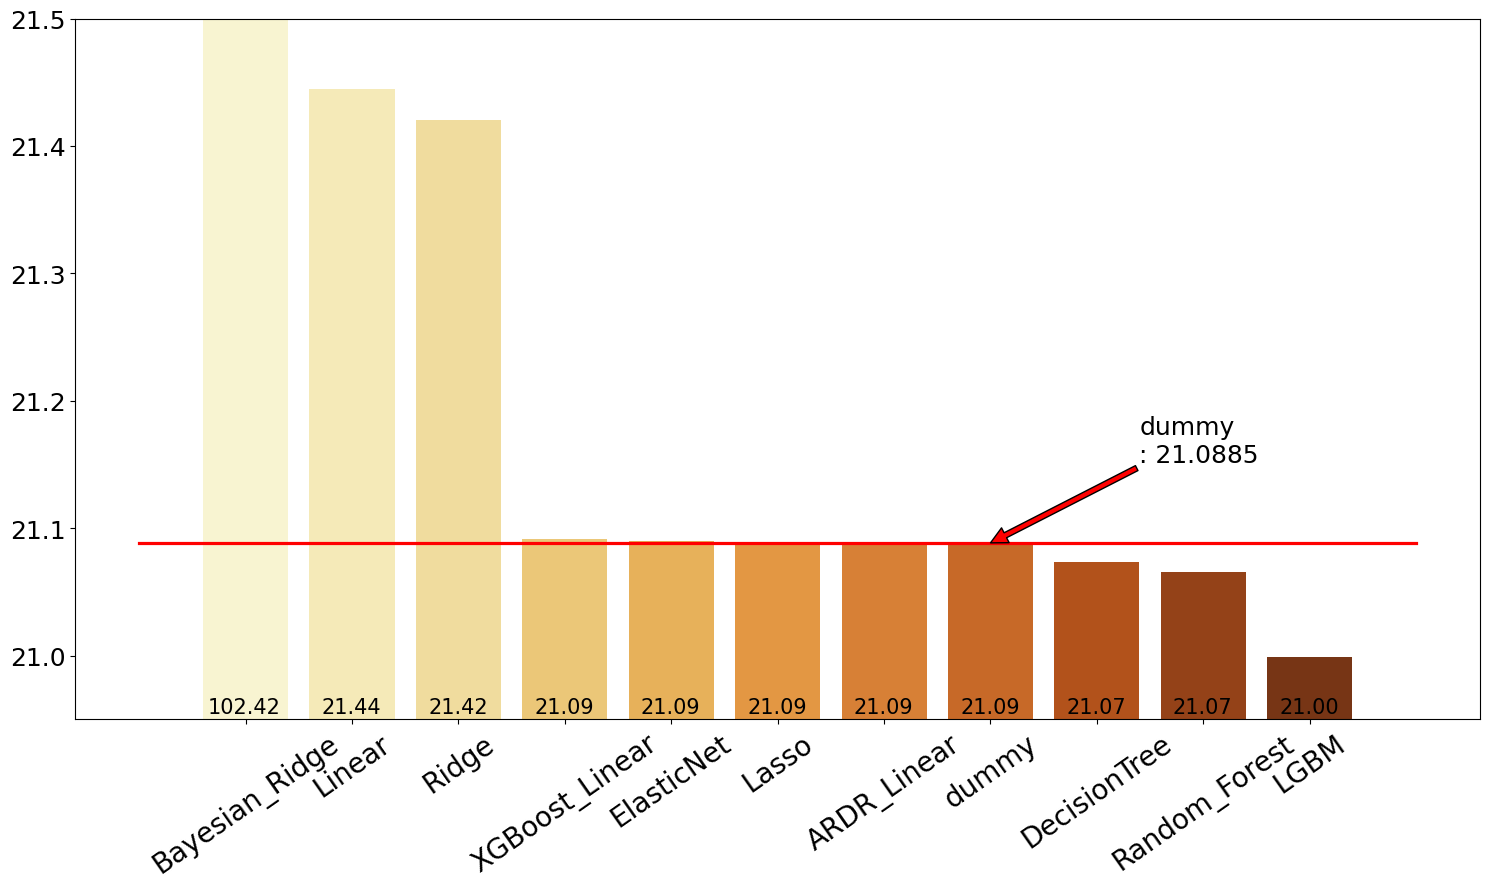

In [34]:
plt.figure(figsize=(15,9), dpi = 100)
g = sns.barplot(x = 'key', y = 'value', data=mse_df, capsize=.2,
                palette = "YlOrBr")
_ = g.set_xticks(range(len(mse_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("", fontsize = 28)
_ = g.set_ylabel("", fontsize = 25)
_ = g.set_ylim([20.95, 21.5]) # g.set_ylim([0, 18]) # ax.set(ylim=(0.4, 0.6))

mse_dummy_mean = mse_df[mse_df.key=='dummy']['value'].values
_ = g.plot([-1,len(mse_df)], [mse_dummy_mean, mse_dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {mse_dummy_mean[0]:.4f}', xy = (7, mse_dummy_mean), xytext = (8.4, 21.1522),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = mse_df['value']
# val = mse_df['value'].sort_values(ascending = False).reset_index(drop = True)
cnt = 0
for i in range(len(mse_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 20.955, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 20.955, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
plt.savefig('[15w] -3 10thr mse_reg_plot.png')

## R2 plot

<Figure size 1500x900 with 0 Axes>

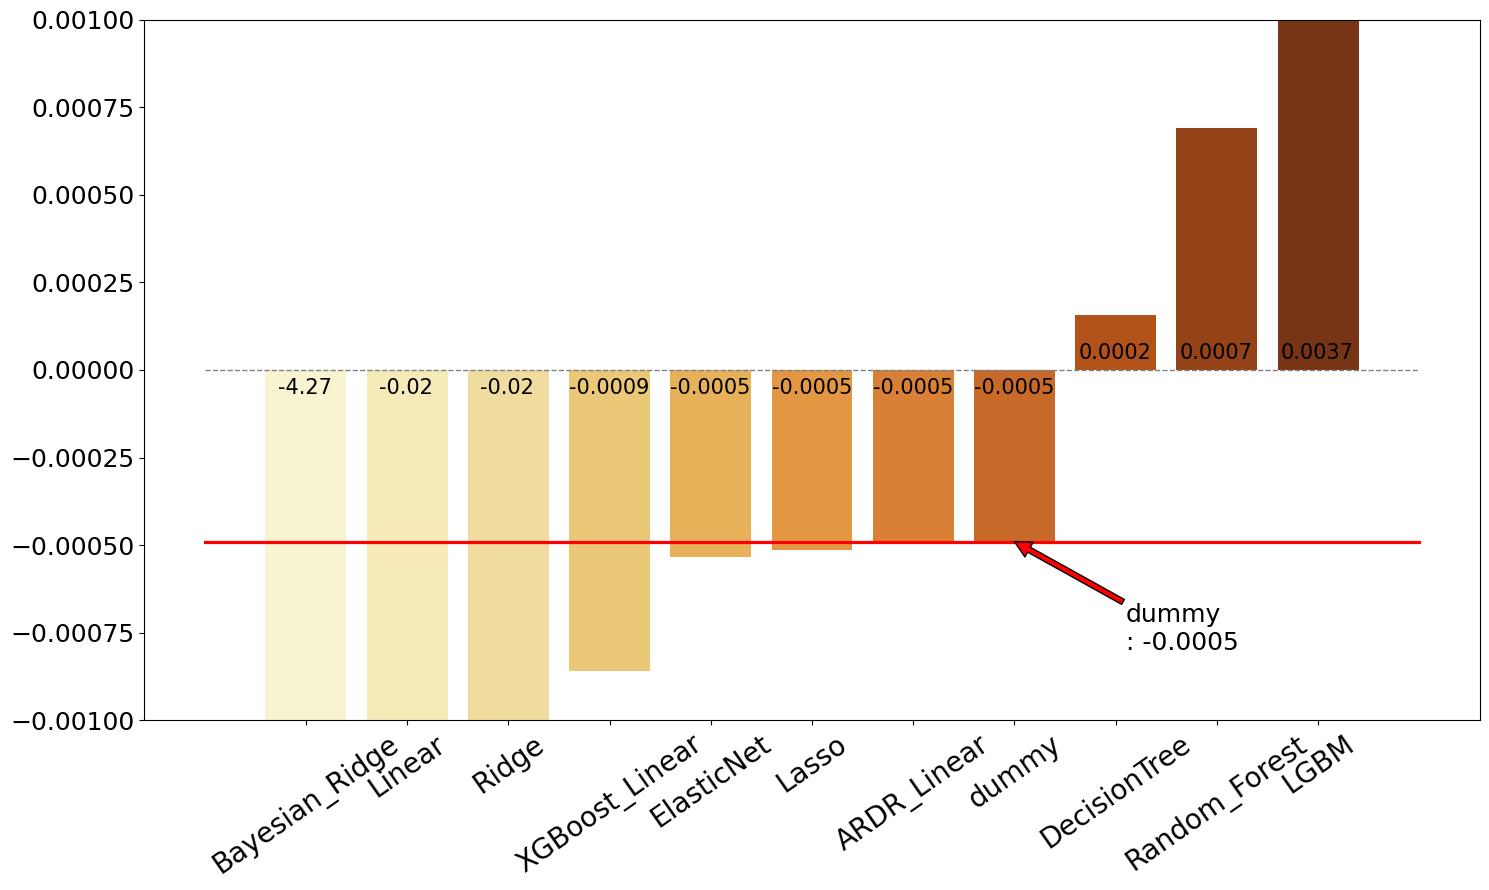

In [35]:
plt.figure(figsize=(15,9), dpi = 100)
g = sns.barplot(x = 'key', y = 'value', data=r2_df, capsize=.2, palette = "YlOrBr")
_ = g.set_xticks(range(len(r2_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("", fontsize = 28)
_ = g.set_ylabel("", fontsize = 25)
_ = g.set_ylim([-0.001, 0.001]) # ax.set(ylim=(0.4, 0.6))
r2_dummy_mean = r2_df[r2_df.key=='dummy']['value'].values
_ = g.plot([-1,len(r2_df)], [r2_dummy_mean, r2_dummy_mean], color = 'red', linewidth = 2.3)
_ = g.plot([-1,len(r2_df)], [0, 0], color = 'gray', linestyle = '--', linewidth = 1)
_ = g.annotate(text = f'dummy\n: {r2_dummy_mean[0]:.4f}', xy = (7, r2_dummy_mean), xytext = (8.1, -0.0008),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = r2_df['value']
cnt = 0
for i in range(len(r2_df)):
    if f'{val[i]:.2f}'[-1] != '0' or f'{val[i]:.2f}'[-2] != '0':
        _ = g.text(cnt-0.28, -0.00007, f'{val[i]:.2f}', fontsize = 15)
    
    elif f'{val[i]:.2f}'[-1] == '0' and val[i] < 0:
#         tmp_val = f'{val[i]:.4f}'[-4:]
#         _ = g.text(cnt-0.47, -0.0001, f'-{tmp_val}'[:3]+'\n'+f'-{tmp_val}'[3:], fontsize = 15)
#         _ = g.text(cnt-0.47, -0.000125, f'{val[i]:.4f}'[:5]+'\n'+'    '+f'{val[i]:.4f}'[5:], fontsize = 15)
        _ = g.text(cnt-0.40, -0.00007, f'{val[i]:.4f}', fontsize = 15)


    elif val[i] > 0:
#         _ = g.text(cnt-0.4, 0.0, f'{val[i]:.4f}'[:4]+'\n'+'   '+f'{val[i]:.4f}'[4:], fontsize = 15)
        _ = g.text(cnt-0.37, 0.00003, f'{val[i]:.4f}', fontsize = 15)
    cnt += 1

plt.tight_layout()
plt.savefig('[15w] -3 10thr r2_reg_plot.png')

# [r2 info](https://vitalflux.com/r-squared-explained-machine-learning/)

# cla modeling

In [11]:
# NextChange
d1221['NextChange'] = np.where(d1221['NextChange']>0.05, 1, 0)

In [12]:
cnt0 = d1221.shape[0] - d1221['NextChange'].sum()
cnt1 = d1221['NextChange'].sum()
cnt1
cnt0-cnt1
(cnt0-cnt1) / d1221.shape[0]
d1221.shape[0]

654194

131483

0.09131581926436466

1439871

In [13]:
from datetime import datetime
# 1. Logistic regression
from sklearn.linear_model import LogisticRegression
# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
# 3. Support vector machine
from sklearn.svm import SVC
# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
# 8. Neural network
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from xgboost import XGBClassifier # decision tree 앙상블 모델, 부스팅
# [light gbm 장점, 하이퍼파라미터 튜닝 방안](https://ariz1623.tistory.com/209)
# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
# [XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)


from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

# 모델 평가 지표 scoring metrics
from sklearn.model_selection import cross_val_score # model 검증

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

import ast # convert string to function

# [scikit-learn classifier metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)
# [classification metrics 1](https://hong-yp-ml-records.tistory.com/29)
# [classification metrics 2](https://sw-data.tistory.com/23) -> regression metrics 참고

results = []
def my_classifier():
    
    # X, y
    X = d1221.iloc[:,2:-1] # 1221 데이터
    y = d1221.iloc[:,-1]
    
    # seed 고정
    user_seed = 0
    random.seed(user_seed) # seed 고정
    
    # 모델
    # (같은 줄에 써놓은 애들끼리 하이퍼파리미터 구성 비슷하거나 같음)
    Logistic_Regression = LogisticRegression(n_jobs=64,
                                             random_state=user_seed,
                                             max_iter=10) # , verbose = 1
    # [모델훈련](https://taek98.tistory.com/15)

    DecisionTree = DecisionTreeClassifier(max_depth = 10,
                                          random_state=user_seed,
                                          max_leaf_nodes=4)
    
    RandomForest = RandomForestClassifier(n_estimators=10,
                                          max_depth=10,
                                          random_state=user_seed,
                                          max_leaf_nodes=4,
                                          n_jobs=64) # , verbose=1
    
    GradientBoosting = GradientBoostingClassifier(n_estimators=10,
                                                  max_depth = 10,
                                                  random_state = user_seed,
                                                  max_leaf_nodes=4,
                                                  learning_rate=0.05) # , verbose = 1
    
    SVM = SVC(max_iter=1000,
              random_state=user_seed) # , verbose=True
    
    Gaussian_NB = GaussianNB()
    KNeighbors = KNeighborsClassifier(n_jobs = 64)
    MLP = MLPClassifier(max_iter=1000,
                        batch_size = 10000,
                        shuffle=True,
                        random_state = user_seed,
                        early_stopping=True) # early_stopping 있어서 max_iter 키움., verbose=True

    XGBoost = XGBClassifier(n_jobs=64,
                            max_depth=10,
                            n_estimators=10,
                            learning_rate=0.05,
                            random_state = user_seed) # early_stopping_rounds = 50,
    # [XGBoost Classifier hyper params](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
    LGBM = lgb.LGBMClassifier(num_leaves=15,
                              learning_rate=0.05,
                              n_estimators=10,
                              max_depth = 10,
                              random_state = user_seed) # early_stopping_rounds, best_iteration_,
    # max_depth : 과적합 방지를 위해 깊이 크기 제한
    # n_estimators : 너무 크면 과적합, 성능저하
    # learning_rate 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다.
    # [LGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
    
    # [gbm grid CV, best_iteration_ 참고](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py)
    # [how to save model to best iteration if early stopping does not happen?](https://github.com/Microsoft/LightGBM/issues/1683)
    
    dummy = DummyClassifier(strategy = 'stratified', random_state = user_seed) # strategy 옵션: 'stratified', 'uniform', 'most_frequent'
    
    my_model_list = ['MLP', 'DecisionTree', 'RandomForest', 'GradientBoosting',
                     'XGBoost', 'dummy', 'Logistic_Regression', 'SVM', 'Gaussian_NB'] # 실수로 빼먹ㅇ서 다시
    # 'LGBM', 'KNeighbors' 서버 자꾸 터져서 뺍니다
    # , 끝나서 뺍니다.
    
    i = 0
    
    ######################################################################### fitting
    for model_nm in tqdm(my_model_list):
        print(f'<<<---{model_nm} start--->>>')
        print(datetime.now().strftime('%H:%M:%S'))
        cntcnt = 0
        # cv # 년도 나눠지는 것에 따라서 개수 정함.
        for slicer in slicing_dic:
            print(f'<<<---{slicer} start--->>>')
            print(datetime.now().strftime('%H:%M:%S'))
            tmpX = X[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # X를 연속 4년치 꺼내서 reset_index(drop = True)
            tmpy = y[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # y를 연속 4년치 꺼내서 reset_index(drop = True)
#             tmp_all = d1221[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # 전체데이터

            X_train = tmpX[:-slicing_dic[slicer][2]] # 기준년도 앞
            X_test = tmpX[-slicing_dic[slicer][2]:] # 기준년도 이하
            y_train = tmpy[:-slicing_dic[slicer][2]] # 기준년도 앞
            y_test = tmpy[-slicing_dic[slicer][2]:] # 기준년도 이하
            
            # train끼리 idx 같아야 하므로
            len_train = slicing_dic[slicer][1]-(slicing_dic[slicer][2]+slicing_dic[slicer][0]) # 혹은 tmp_train.shape[0]
            len(list(range(len_train)))
            train_idx = list(range(len_train))
            random.shuffle(train_idx) # 자동으로 덮어쓰기
            
            # test끼리 idx 같아야 하므로
            len_train_to_test = slicing_dic[slicer][1]-slicing_dic[slicer][0]
            test_idx = list(range(len_train,len_train_to_test)) # +1 안해줘도 되는 거 위 cell에서 확인
            len(test_idx)
            random.shuffle(test_idx) # 자동으로 덮어쓰기
            
            X_train = X_train.loc[train_idx]
            y_train = y_train.loc[train_idx]
            X_test = X_test.loc[test_idx]
            y_test = y_test.loc[test_idx]
            ###########################################
            y_train = np.array(y_train).reshape(-1,1) # 1열짜리로 만드는 것
            y_test = np.array(y_test).reshape(-1,1)

            ######################################################## cv를 위한 데이터 slicing 작업 끝

            # fitting은 cv 안에 넣기
            if model_nm == 'LGBM':
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='auc',
                                            early_stopping_rounds=5) # map: mean average precision
                # eval_metric = logloss, auc, error
                y_pred_test = model_.predict(X_test, num_iteration=LGBM.best_iteration_) # 예측
            # If early stopping occurs, the model will have three additional fields: best_score, best_iteration and best_ntree_limit
            # [eval_metric](https://stats.stackexchange.com/questions/493981/xgboost-mean-average-precision-eval-metric-for-classification)
            # [gbm.fit verbose = 10, #verbose = 10 : 10번 반복할 때마다 logloss값을 보여준다.](https://dacon.io/codeshare/1827)
            # [Classifier, Regressor eval_metric 예시](https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost)
            # [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#)
            # error: For MAP metric, there should be query information
            elif model_nm == 'XGBoost': # xgboost_linear가 느려서
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='auc',
                                            early_stopping_rounds=5) # ,verbose = True
                y_pred_test = model_.predict(X_test) # 예측
            
            else:
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train)
                y_pred_test = model_.predict(X_test) # 예측

            accuracy = accuracy_score(y_test, y_pred_test)
            roc_auc = roc_auc_score(y_test, y_pred_test)
#             f1 = f1_score(y_test, y_pred_test)
#             jaccard = jaccard_score(y_test, y_pred_test)
#             cv_scores = cross_val_score(eval(model_nm), tmpX, tmpy, cv=7, n_jobs = 64)
            
#             _ = dummy.fit(X_train, y_train)
#             dummy_score = dummy.score(X_test, y_test)

            results.append([i, f'{model_nm}', accuracy, roc_auc]) # , f1, jaccard, dummy_score, cv_scores
            i+=1
        ################################################################
        print(results[-7:])
    return results#score_dic#[0]

In [14]:
import time
start = time.time()
_ = my_classifier()
results
time.time()-start

# ['KNeighbor']

  0%|                                                     | 0/1 [00:00<?, ?it/s]

<<<---KNeighbors start--->>>
13:12:15
<<<---1215 start--->>>
13:12:15
$$$$$---1


  0%|                                                     | 0/1 [06:42<?, ?it/s]


KeyboardInterrupt: 

In [18]:
import time
start = time.time()
_ = my_classifier()
results
time.time()-start

# ['XGBoost', 'dummy', 'Logistic_Regression', 'SVM', 'Gaussian_NB']

  0%|                                                     | 0/5 [00:00<?, ?it/s]

<<<---XGBoost start--->>>
00:28:53
<<<---1215 start--->>>
00:28:53
$$$$$---1
[0]	validation_0-auc:0.53245
[1]	validation_0-auc:0.53767
[2]	validation_0-auc:0.54114
[3]	validation_0-auc:0.54327
[4]	validation_0-auc:0.54542
[5]	validation_0-auc:0.54592
[6]	validation_0-auc:0.54673
[7]	validation_0-auc:0.54795
[8]	validation_0-auc:0.54953
[9]	validation_0-auc:0.54993
<<<---1316 start--->>>
00:29:09
$$$$$---2
[0]	validation_0-auc:0.53576
[1]	validation_0-auc:0.54283
[2]	validation_0-auc:0.54527
[3]	validation_0-auc:0.54902
[4]	validation_0-auc:0.55135
[5]	validation_0-auc:0.55196
[6]	validation_0-auc:0.55288
[7]	validation_0-auc:0.55356
[8]	validation_0-auc:0.55481
[9]	validation_0-auc:0.55558
<<<---1417 start--->>>
00:29:26
$$$$$---3
[0]	validation_0-auc:0.53724
[1]	validation_0-auc:0.54198
[2]	validation_0-auc:0.54494
[3]	validation_0-auc:0.54782
[4]	validation_0-auc:0.54903
[5]	validation_0-auc:0.54982
[6]	validation_0-auc:0.55069
[7]	validation_0-auc:0.55127
[8]	validation_0-auc:0.5521

 20%|████████▊                                   | 1/5 [02:14<08:57, 134.49s/it]

[[0, 'XGBoost', 0.5533303429845786, 0.5274938602009643], [1, 'XGBoost', 0.5587648512640324, 0.528969220742626], [2, 'XGBoost', 0.5608311819609684, 0.5267130683977462], [3, 'XGBoost', 0.5525027920342322, 0.5209610157365271], [4, 'XGBoost', 0.5596736996872831, 0.52162189127671], [5, 'XGBoost', 0.5382265473507089, 0.51353989896573], [6, 'XGBoost', 0.5546100115373264, 0.5134707222923052]]
<<<---dummy start--->>>
00:31:08
<<<---1215 start--->>>
00:31:08
$$$$$---1
<<<---1316 start--->>>
00:31:10
$$$$$---2
<<<---1417 start--->>>
00:31:12
$$$$$---3
<<<---1518 start--->>>
00:31:14
$$$$$---4
<<<---1619 start--->>>
00:31:16
$$$$$---5
<<<---1720 start--->>>
00:31:18
$$$$$---6
<<<---1821 start--->>>
00:31:21


 40%|██████████████████                           | 2/5 [02:30<03:14, 64.72s/it]

$$$$$---7
[[7, 'dummy', 0.5022901438526222, 0.498624936882785], [8, 'dummy', 0.5004764315278564, 0.4967955180971402], [9, 'dummy', 0.5074560849235435, 0.5029978207328746], [10, 'dummy', 0.505364470266404, 0.5009225744971062], [11, 'dummy', 0.5049818265951175, 0.4999652479913408], [12, 'dummy', 0.5033045841262985, 0.5000358456090245], [13, 'dummy', 0.5045702122331435, 0.5002466642274119]]
<<<---Logistic_Regression start--->>>
00:31:24
<<<---1215 start--->>>
00:31:24
$$$$$---1
<<<---1316 start--->>>
00:32:33
$$$$$---2
<<<---1417 start--->>>
00:33:44
$$$$$---3
<<<---1518 start--->>>
00:34:57
$$$$$---4
<<<---1619 start--->>>
00:36:13
$$$$$---5
<<<---1720 start--->>>
00:37:27
$$$$$---6


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<<<---1821 start--->>>
00:38:49
$$$$$---7


 60%|██████████████████████████▍                 | 3/5 [11:32<09:25, 282.85s/it]

[[14, 'Logistic_Regression', 0.5388124103685078, 0.5006451548065087], [15, 'Logistic_Regression', 0.5422460768841378, 0.4992190478424038], [16, 'Logistic_Regression', 0.5529598671264285, 0.49972436498512524], [17, 'Logistic_Regression', 0.5486315895144998, 0.4997338524721153], [18, 'Logistic_Regression', 0.5520610208453058, 0.5000000566565985], [19, 'Logistic_Regression', 0.5322787458327147, 0.49968927327232476], [20, 'Logistic_Regression', 0.5521326166477359, 0.4998208245751821]]
<<<---SVM start--->>>
00:40:26
<<<---1215 start--->>>
00:40:26
$$$$$---1


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

<<<---1316 start--->>>
00:46:23
$$$$$---2
<<<---1417 start--->>>
00:52:44
$$$$$---3
<<<---1518 start--->>>
00:59:01
$$$$$---4
<<<---1619 start--->>>
01:06:26
$$$$$---5
<<<---1720 start--->>>
01:13:20
$$$$$---6
<<<---1821 start--->>>
01:21:03
$$$$$---7


 80%|████████████████████████████████▊        | 4/5 [1:01:38<22:37, 1357.74s/it]

[[21, 'SVM', 0.45822461730906516, 0.4999856282727155], [22, 'SVM', 0.45512610547002946, 0.500040258196378], [23, 'SVM', 0.4466339296997707, 0.5000869632262043], [24, 'SVM', 0.45129311967474367, 0.500225094814467], [25, 'SVM', 0.44796136938658226, 0.5001228231705257], [26, 'SVM', 0.46762677320519913, 0.5002860894098915], [27, 'SVM', 0.44784502419261074, 0.5001912401255232]]
<<<---Gaussian_NB start--->>>
01:30:32
<<<---1215 start--->>>
01:30:32
$$$$$---1
<<<---1316 start--->>>
01:30:36
$$$$$---2
<<<---1417 start--->>>
01:30:41
$$$$$---3
<<<---1518 start--->>>
01:30:45
$$$$$---4
<<<---1619 start--->>>
01:30:51
$$$$$---5
<<<---1720 start--->>>
01:30:56
$$$$$---6
<<<---1821 start--->>>
01:31:02
$$$$$---7


100%|██████████████████████████████████████████| 5/5 [1:02:16<00:00, 747.21s/it]

[[28, 'Gaussian_NB', 0.4585847226872706, 0.5001861170154632], [29, 'Gaussian_NB', 0.45533454426346665, 0.4999844005243526], [30, 'Gaussian_NB', 0.44699499918759367, 0.5000782161269514], [31, 'Gaussian_NB', 0.4513872331881894, 0.5001233864776655], [32, 'Gaussian_NB', 0.44796883279721167, 0.5001437873510062], [33, 'Gaussian_NB', 0.467739250541016, 0.5003228724449605], [34, 'Gaussian_NB', 0.44788974251191743, 0.500238357284859]]


[[0, 'XGBoost', 0.5533303429845786, 0.5274938602009643],
 [1, 'XGBoost', 0.5587648512640324, 0.528969220742626],
 [2, 'XGBoost', 0.5608311819609684, 0.5267130683977462],
 [3, 'XGBoost', 0.5525027920342322, 0.5209610157365271],
 [4, 'XGBoost', 0.5596736996872831, 0.52162189127671],
 [5, 'XGBoost', 0.5382265473507089, 0.51353989896573],
 [6, 'XGBoost', 0.5546100115373264, 0.5134707222923052],
 [7, 'dummy', 0.5022901438526222, 0.498624936882785],
 [8, 'dummy', 0.5004764315278564, 0.4967955180971402],
 [9, 'dummy', 0.5074560849235435, 0.5029978207328746],
 [10, 'dummy', 0.505364470266404, 0.5009225744971062],
 [11, 'dummy', 0.5049818265951175, 0.4999652479913408],
 [12, 'dummy', 0.5033045841262985, 0.5000358456090245],
 [13, 'dummy', 0.5045702122331435, 0.5002466642274119],
 [14, 'Logistic_Regression', 0.5388124103685078, 0.5006451548065087],
 [15, 'Logistic_Regression', 0.5422460768841378, 0.4992190478424038],
 [16, 'Logistic_Regression', 0.5529598671264285, 0.49972436498512524],
 [17, 'L

3737.171305656433

In [ ]:
import time
start = time.time()
_ = my_classifier()
results
time.time()-start

# ['MLP', 'DecisionTree', 'RandomForest', 'GradientBoosting','KNeighbors']

# local variable 변수명 referenced before assignment
# 함수 밖에서 설정한 변수를 함수 안에서 쓰려고 할 때 발생하는 에러

### cv_scores가 빠져서 그런가 tree기반이 빨라짐. 고로 튜닝 좀더 깊게 해도 될 것 같음.

  0%|                                                     | 0/5 [00:00<?, ?it/s]

<<<---MLP start--->>>
18:39:34
<<<---1215 start--->>>
18:39:34
$$$$$---1
<<<---1316 start--->>>
18:40:03
$$$$$---2
<<<---1417 start--->>>
18:41:33
$$$$$---3
<<<---1518 start--->>>
18:42:22
$$$$$---4
<<<---1619 start--->>>
18:43:33
$$$$$---5
<<<---1720 start--->>>
18:44:36
$$$$$---6
<<<---1821 start--->>>
18:45:21
$$$$$---7


 20%|████████▊                                   | 1/5 [07:26<29:47, 446.99s/it]

[[0, 'MLP', 0.5070852312571468, 0.4981315384745352], [1, 'MLP', 0.5270523776910937, 0.4990287907340827], [2, 'MLP', 0.5287501579679009, 0.5006602983405445], [3, 'MLP', 0.5422193221317338, 0.5009435972809749], [4, 'MLP', 0.5345817131512759, 0.49794460684853803], [5, 'MLP', 0.5199872225746512, 0.5030644735501303], [6, 'MLP', 0.5424779315094221, 0.5025564917597585]]
<<<---DecisionTree start--->>>
18:47:01
<<<---1215 start--->>>
18:47:01
$$$$$---1
<<<---1316 start--->>>
18:48:20
$$$$$---2
<<<---1417 start--->>>
18:50:12
$$$$$---3
<<<---1518 start--->>>
18:51:59
$$$$$---4
<<<---1619 start--->>>
18:54:00
$$$$$---5
<<<---1720 start--->>>
18:56:09
$$$$$---6
<<<---1821 start--->>>
18:58:23
$$$$$---7


 40%|█████████████████▌                          | 2/5 [21:05<33:16, 665.36s/it]

[[7, 'DecisionTree', 0.5477202802504312, 0.5177220448987767], [8, 'DecisionTree', 0.5436307060119704, 0.5164708209157598], [9, 'DecisionTree', 0.5499088299543247, 0.5111833363647642], [10, 'DecisionTree', 0.5475963408665973, 0.5227744579502975], [11, 'DecisionTree', 0.5525536059468455, 0.5023766400076397], [12, 'DecisionTree', 0.5365933764346484, 0.5119752568734229], [13, 'DecisionTree', 0.5529464900591177, 0.5114457071075491]]
<<<---RandomForest start--->>>
19:00:39
<<<---1215 start--->>>
19:00:39
$$$$$---1
<<<---1316 start--->>>
19:00:43
$$$$$---2
<<<---1417 start--->>>
19:00:48
$$$$$---3
<<<---1518 start--->>>
19:00:53
$$$$$---4
<<<---1619 start--->>>
19:00:59
$$$$$---5
<<<---1720 start--->>>
19:01:05
$$$$$---6
<<<---1821 start--->>>
19:01:11
$$$$$---7


 60%|██████████████████████████▍                 | 3/5 [21:44<12:39, 379.66s/it]

[[14, 'RandomForest', 0.5455091068754857, 0.5059471462013954], [15, 'RandomForest', 0.5504347437691689, 0.5089746337276014], [16, 'RandomForest', 0.5559567438753588, 0.5083075846348538], [17, 'RandomForest', 0.5557904907706015, 0.5117567260547392], [18, 'RandomForest', 0.5540089710195766, 0.5052001863636698], [19, 'RandomForest', 0.5336059783953533, 0.5023594017403971], [20, 'RandomForest', 0.5510280741608607, 0.4998035303951165]]
<<<---GradientBoosting start--->>>
19:01:18
<<<---1215 start--->>>
19:01:18
$$$$$---1
<<<---1316 start--->>>
19:15:05
$$$$$---2
<<<---1417 start--->>>
19:31:16
$$$$$---3
<<<---1518 start--->>>
19:48:41
$$$$$---4
<<<---1619 start--->>>
20:07:29
$$$$$---5
<<<---1720 start--->>>
20:24:51
$$$$$---6
<<<---1821 start--->>>
20:43:42
$$$$$---7


 80%|████████████████████████████████▊        | 4/5 [2:24:54<52:27, 3147.09s/it]

[[21, 'GradientBoosting', 0.541781700329149, 0.5], [22, 'GradientBoosting', 0.544978113926689, 0.5], [23, 'GradientBoosting', 0.5536097922045098, 0.5], [24, 'GradientBoosting', 0.5492903841086195, 0.5], [25, 'GradientBoosting', 0.5522998499854463, 0.5], [26, 'GradientBoosting', 0.5328006406709048, 0.5], [27, 'GradientBoosting', 0.5519984616898158, 0.4999027123208462]]
<<<---KNeighbors start--->>>
21:04:28
<<<---1215 start--->>>
21:04:28
$$$$$---1


In [15]:
results = [[0, 'XGBoost', 0.5533303429845786, 0.5274938602009643],
 [1, 'XGBoost', 0.5587648512640324, 0.528969220742626],
 [2, 'XGBoost', 0.5608311819609684, 0.5267130683977462],
 [3, 'XGBoost', 0.5525027920342322, 0.5209610157365271],
 [4, 'XGBoost', 0.5596736996872831, 0.52162189127671],
 [5, 'XGBoost', 0.5382265473507089, 0.51353989896573],
 [6, 'XGBoost', 0.5546100115373264, 0.5134707222923052],
 [7, 'dummy', 0.5022901438526222, 0.498624936882785],
 [8, 'dummy', 0.5004764315278564, 0.4967955180971402],
 [9, 'dummy', 0.5074560849235435, 0.5029978207328746],
 [10, 'dummy', 0.505364470266404, 0.5009225744971062],
 [11, 'dummy', 0.5049818265951175, 0.4999652479913408],
 [12, 'dummy', 0.5033045841262985, 0.5000358456090245],
 [13, 'dummy', 0.5045702122331435, 0.5002466642274119],
 [14, 'Logistic_Regression', 0.5388124103685078, 0.5006451548065087],
 [15, 'Logistic_Regression', 0.5422460768841378, 0.4992190478424038],
 [16, 'Logistic_Regression', 0.5529598671264285, 0.49972436498512524],
 [17, 'Logistic_Regression', 0.5486315895144998, 0.4997338524721153],
 [18, 'Logistic_Regression', 0.5520610208453058, 0.5000000566565985],
 [19, 'Logistic_Regression', 0.5322787458327147, 0.49968927327232476],
 [20, 'Logistic_Regression', 0.5521326166477359, 0.4998208245751821],
 [21, 'SVM', 0.45822461730906516, 0.4999856282727155],
 [22, 'SVM', 0.45512610547002946, 0.500040258196378],
 [23, 'SVM', 0.4466339296997707, 0.5000869632262043],
 [24, 'SVM', 0.45129311967474367, 0.500225094814467],
 [25, 'SVM', 0.44796136938658226, 0.5001228231705257],
 [26, 'SVM', 0.46762677320519913, 0.5002860894098915],
 [27, 'SVM', 0.44784502419261074, 0.5001912401255232],
 [28, 'Gaussian_NB', 0.4585847226872706, 0.5001861170154632],
 [29, 'Gaussian_NB', 0.45533454426346665, 0.4999844005243526],
 [30, 'Gaussian_NB', 0.44699499918759367, 0.5000782161269514],
 [31, 'Gaussian_NB', 0.4513872331881894, 0.5001233864776655],
 [32, 'Gaussian_NB', 0.44796883279721167, 0.5001437873510062],
 [33, 'Gaussian_NB', 0.467739250541016, 0.5003228724449605],
 [34, 'Gaussian_NB', 0.44788974251191743, 0.500238357284859],
 [0, 'MLP', 0.5070852312571468, 0.4981315384745352],
 [1, 'MLP', 0.5270523776910937, 0.4990287907340827],
 [2, 'MLP', 0.5287501579679009, 0.5006602983405445],
 [3, 'MLP', 0.5422193221317338, 0.5009435972809749],
 [4, 'MLP', 0.5345817131512759, 0.49794460684853803],
 [5, 'MLP', 0.5199872225746512, 0.5030644735501303],
 [6, 'MLP', 0.5424779315094221, 0.5025564917597585],
 [7, 'DecisionTree', 0.5477202802504312, 0.5177220448987767],
 [8, 'DecisionTree', 0.5436307060119704, 0.5164708209157598],
 [9, 'DecisionTree', 0.5499088299543247, 0.5111833363647642],
 [10, 'DecisionTree', 0.5475963408665973, 0.5227744579502975],
 [11, 'DecisionTree', 0.5525536059468455, 0.5023766400076397],
 [12, 'DecisionTree', 0.5365933764346484, 0.5119752568734229],
 [13, 'DecisionTree', 0.5529464900591177, 0.5114457071075491],
 [14, 'RandomForest', 0.5455091068754857, 0.5059471462013954],
 [15, 'RandomForest', 0.5504347437691689, 0.5089746337276014],
 [16, 'RandomForest', 0.5559567438753588, 0.5083075846348538],
 [17, 'RandomForest', 0.5557904907706015, 0.5117567260547392],
 [18, 'RandomForest', 0.5540089710195766, 0.5052001863636698],
 [19, 'RandomForest', 0.5336059783953533, 0.5023594017403971],
 [20, 'RandomForest', 0.5510280741608607, 0.4998035303951165],
 [21, 'GradientBoosting', 0.541781700329149, 0.5],
 [22, 'GradientBoosting', 0.544978113926689, 0.5],
 [23, 'GradientBoosting', 0.5536097922045098, 0.5],
 [24, 'GradientBoosting', 0.5492903841086195, 0.5],
 [25, 'GradientBoosting', 0.5522998499854463, 0.5],
 [26, 'GradientBoosting', 0.5328006406709048, 0.5],
 [27, 'GradientBoosting', 0.5519984616898158, 0.4999027123208462]
]

In [16]:
for i in range(len(results)):
    results[i][0] = i

results

[[0, 'XGBoost', 0.5533303429845786, 0.5274938602009643],
 [1, 'XGBoost', 0.5587648512640324, 0.528969220742626],
 [2, 'XGBoost', 0.5608311819609684, 0.5267130683977462],
 [3, 'XGBoost', 0.5525027920342322, 0.5209610157365271],
 [4, 'XGBoost', 0.5596736996872831, 0.52162189127671],
 [5, 'XGBoost', 0.5382265473507089, 0.51353989896573],
 [6, 'XGBoost', 0.5546100115373264, 0.5134707222923052],
 [7, 'dummy', 0.5022901438526222, 0.498624936882785],
 [8, 'dummy', 0.5004764315278564, 0.4967955180971402],
 [9, 'dummy', 0.5074560849235435, 0.5029978207328746],
 [10, 'dummy', 0.505364470266404, 0.5009225744971062],
 [11, 'dummy', 0.5049818265951175, 0.4999652479913408],
 [12, 'dummy', 0.5033045841262985, 0.5000358456090245],
 [13, 'dummy', 0.5045702122331435, 0.5002466642274119],
 [14, 'Logistic_Regression', 0.5388124103685078, 0.5006451548065087],
 [15, 'Logistic_Regression', 0.5422460768841378, 0.4992190478424038],
 [16, 'Logistic_Regression', 0.5529598671264285, 0.49972436498512524],
 [17, 'L

## plot을 위한 준비

In [17]:
model_list = ['Logistic_Regression', 'SVM', 'Gaussian_NB',
              'MLP',
              'DecisionTree', 'RandomForest', 'GradientBoosting',
              'XGBoost', 'dummy'] #  'LGBM', 'KNeighbors',
acc_dic = {i:[] for i in model_list}
rocauc_dic = {i:[] for i in model_list}

for i in results:
    acc_dic[i[1]].append(i[2])
    rocauc_dic[i[1]].append(i[3])

# import math
# 리스트에 mean 함수가 내장이 안돼있다니...
mean_acc_score = {i:[] for i in model_list}
mean_rocauc_score = {i:[] for i in model_list}

for i in model_list:
    mean_acc_score[i] = sum(acc_dic[i])/len(acc_dic[i])
    mean_rocauc_score[i] = sum(rocauc_dic[i])/len(rocauc_dic[i])

# 정렬
acc_score_lst = sorted(mean_acc_score.items(), key = lambda t : t[1]) #acc 작은 순으로 줄 세워짐.
rocauc_score_lst = sorted(mean_rocauc_score.items(), key = lambda t : t[1]) #rocauc 작은 순으로 줄 세워짐.

acc_score_lst
rocauc_score_lst


[('SVM', 0.4535301341340001),
 ('Gaussian_NB', 0.4536999035966664),
 ('dummy', 0.5040633933607123),
 ('MLP', 0.5288791366118893),
 ('Logistic_Regression', 0.5455889038884757),
 ('GradientBoosting', 0.5466798489878764),
 ('DecisionTree', 0.5472785185034194),
 ('RandomForest', 0.5494763012666294),
 ('XGBoost', 0.5539913466884472)]

[('Logistic_Regression', 0.4998332249443226),
 ('dummy', 0.4999412297196691),
 ('GradientBoosting', 0.4999861017601209),
 ('SVM', 0.5001340138879579),
 ('Gaussian_NB', 0.5001538767464655),
 ('MLP', 0.5003328281412235),
 ('RandomForest', 0.5060498870168246),
 ('DecisionTree', 0.5134211805883158),
 ('XGBoost', 0.5218242396589441)]

In [18]:
# 다시 dic
acc_score_dic = {}
rocauc_score_dic = {}

for i in acc_score_lst:
    acc_score_dic[i[0]] = i[1]
rocauc_score_dic = {i[0]:i[1] for i in rocauc_score_lst}

In [19]:
acc_df = pd.DataFrame(acc_score_dic.items(), columns=['key', 'value'])
acc_df

rocauc_df = pd.DataFrame(rocauc_score_dic.items(), columns=['key', 'value'])
rocauc_df

,key,value
0,SVM,0.453530
1,Gaussian_NB,0.453700
2,dummy,0.504063
3,MLP,0.528879
4,Logistic_Regression,0.545589
5,GradientBoosting,0.546680
6,DecisionTree,0.547279
7,RandomForest,0.549476
8,XGBoost,0.553991


,key,value
0,Logistic_Regression,0.499833
1,dummy,0.499941
2,GradientBoosting,0.499986
3,SVM,0.500134
4,Gaussian_NB,0.500154
5,MLP,0.500333
6,RandomForest,0.506050
7,DecisionTree,0.513421
8,XGBoost,0.521824


## plot

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# acc

<Figure size 1500x900 with 0 Axes>

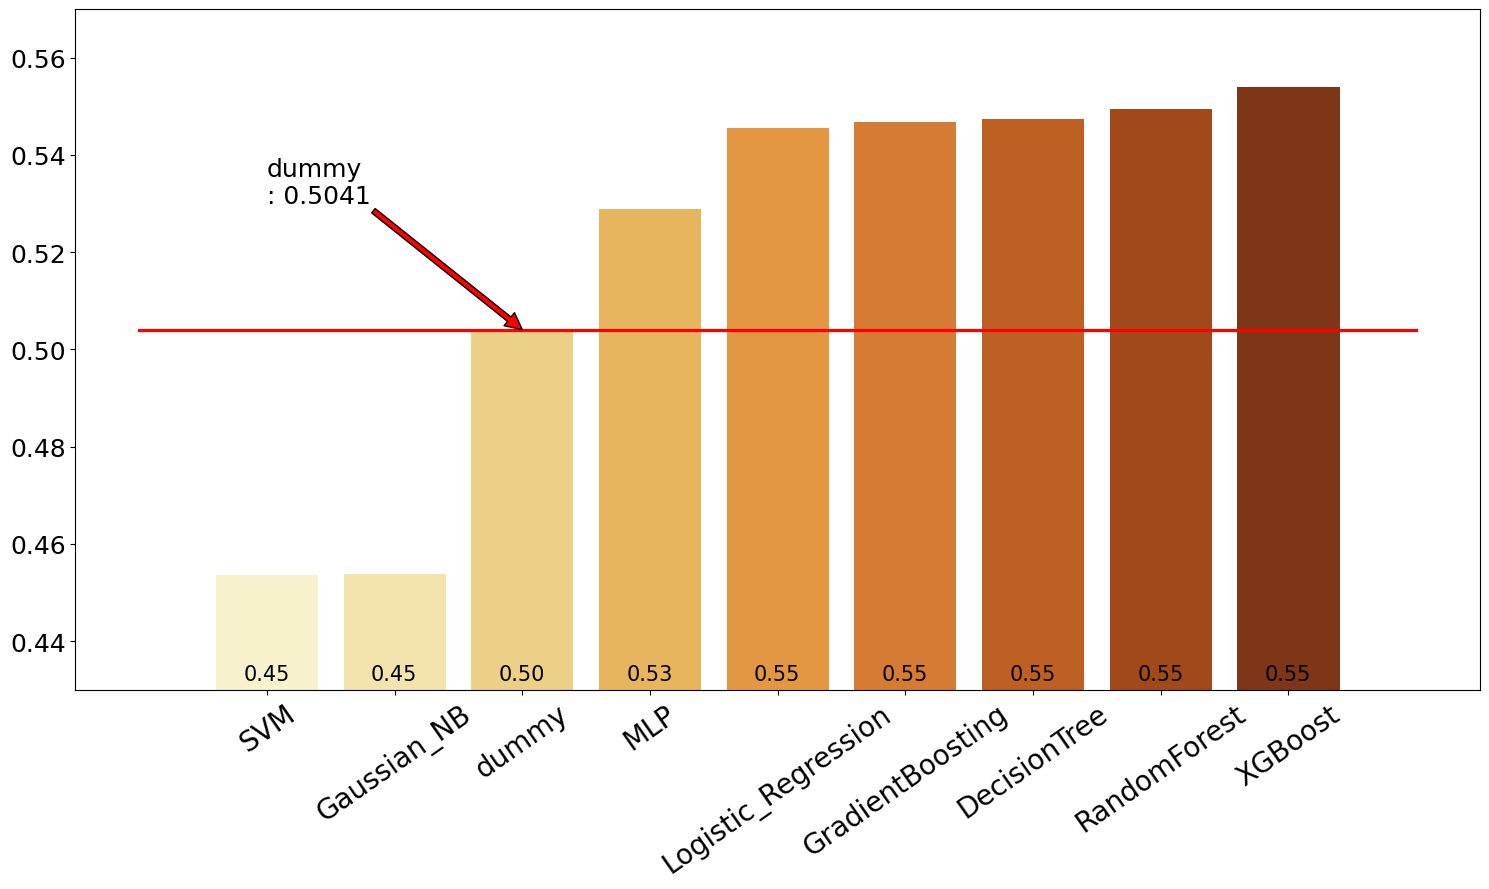

In [21]:
plt.figure(figsize=(15,9), dpi = 100)
# colors = sns.color_palette('hls',len(model_list))
g = sns.barplot(x = 'key', y = 'value', data=acc_df, capsize=.2, palette = "YlOrBr") # , color = colors
_ = g.set_xticks(range(len(acc_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("", fontsize = 28)
_ = g.set_ylabel("", fontsize = 25)
_ = g.set_ylim([0.43, 0.57]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = acc_df[acc_df.key=='dummy']['value'].values
_ = g.plot([-1,len(acc_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (2, dummy_mean), xytext = (0, 0.53),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)

val = acc_df['value']
cnt = 0
for i in range(len(acc_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 0.432, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 0.432, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.432, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
plt.savefig('[15w] -3 10thr acc_cla_plot.png')

<Figure size 1500x900 with 0 Axes>

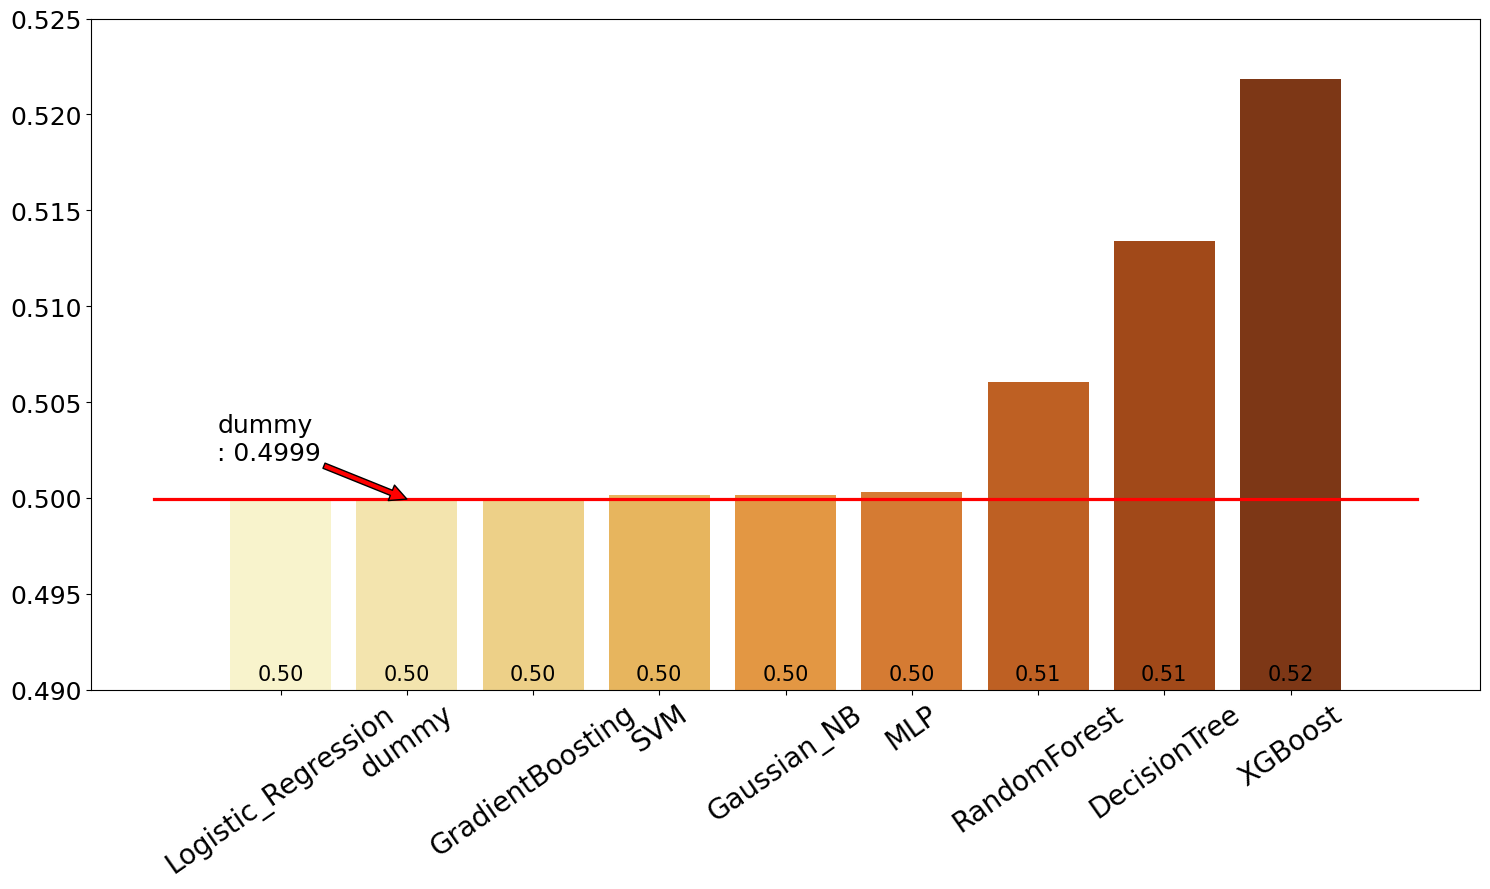

In [22]:
plt.figure(figsize=(15,9), dpi = 100)
g = sns.barplot(x = 'key', y = 'value', data=rocauc_df, capsize=.2, palette = "YlOrBr")
_ = g.set_xticks(range(len(rocauc_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("", fontsize = 28)
_ = g.set_ylabel("", fontsize = 25)
_ = g.set_ylim([0.49, 0.525]) # g.set_ylim([0, 18]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = rocauc_df[rocauc_df.key=='dummy']['value'].values
_ = g.plot([-1,len(rocauc_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (1, dummy_mean), xytext = (-0.5, 0.502),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = rocauc_df['value']
cnt = 0
for i in range(len(rocauc_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 16.05, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 16.05, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.4905, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
plt.savefig('[15w] -3 10thr rocauc_cla_plot.png')